In [36]:
import os
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.functions import (
    col, lit, sum, mean, when,
    explode, count, desc, floor,
    corr, array_contains, lit, first
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 1 Test")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

In [38]:
conf = create_spark_configuration()

In [39]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

24/12/02 00:05:32 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
24/12/02 00:05:52 WARN Client: Same path resource file:///home/user1/.ivy2/jars/org.apache.iceberg_iceberg-spark-runtime-3.5_2.12-1.6.0.jar added multiple times to distributed cache.


In [40]:
database_name = "lopin_database1"

In [41]:
spark.catalog.setCurrentDatabase(database_name)

In [42]:
df = spark.table("sobd_lab1_table")

In [43]:
df.show()

+----------+----------+--------------------+--------+-------+
|event_type|product_id|       category_code|   brand|  price|
+----------+----------+--------------------+--------+-------+
|      view|  44600062|                NULL|shiseido|  35.79|
|      view|   3900821|appliances.enviro...|    aqua|   33.2|
|      view|  17200506|furniture.living_...|    NULL|  543.1|
|      view|   1307067|  computers.notebook|  lenovo| 251.74|
|      view|   1004237|electronics.smart...|   apple|1081.98|
|      view|   1480613|   computers.desktop|  pulser| 908.62|
|      view|  17300353|                NULL|   creed| 380.96|
|      view|  31500053|                NULL|luminarc|  41.16|
|      view|  28719074|  apparel.shoes.keds|   baden| 102.71|
|      view|   1004545|electronics.smart...|  huawei| 566.01|
|      view|   2900536|appliances.kitche...|elenberg|  51.46|
|      view|   1005011|electronics.smart...| samsung| 900.64|
|      view|   3900746|appliances.enviro...|   haier| 102.38|
|      v

In [44]:
df.printSchema()

root
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)



In [45]:
df.count()

42448764

EVENT_TYPE

In [46]:
df.orderBy("event_type", ascending=False).show()

+----------+----------+--------------------+---------+-------+
|event_type|product_id|       category_code|    brand|  price|
+----------+----------+--------------------+---------+-------+
|      view|   1201368|  electronics.tablet|prestigio|  99.09|
|      view|   7901061|furniture.kitchen...|     NULL|  51.22|
|      view|  26400180|                NULL|     NULL| 261.53|
|      view|   1307073|  computers.notebook|     acer| 720.48|
|      view|   5701166|auto.accessories....|     NULL|  136.4|
|      view|   1700954|computers.periphe...|  samsung| 223.68|
|      view|  21402224|  electronics.clocks|    casio|  74.65|
|      view|   5100182|                NULL|     moov|  51.41|
|      view|   1004739|electronics.smart...|   xiaomi| 188.02|
|      view|   1004872|electronics.smart...|  samsung| 292.08|
|      view|  35200447|   apparel.underwear|milavitsa|   9.52|
|      view|   1201216|  electronics.tablet|   lenovo| 253.43|
|      view|   4400392|appliances.kitche...|     smeg|2

In [47]:
df.select('event_type').distinct().show()

+----------+
|event_type|
+----------+
|  purchase|
|      view|
|      cart|
+----------+



CATEGORY_CODE

In [48]:
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

In [49]:
count_nulls(data=df, column_name="category_code")


Число колонок с NULL: 13515609 (31.84%)


In [50]:
df = df.fillna({"category_code": "Unknown"})
count_nulls(data=df, column_name="category_code")

Число колонок с NULL: 0 (0.00%)


In [51]:
def plot_cat_distribution(data: DataFrame,
                          column_name: str,
                          top_n: int = 20) -> None:
    """
    Построение распределения категориального признака.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для группировки.
        top_n (int): Количество топ-значений для отображения.
    
    Returns:
        None
    """
    # Группировка данных по столбцу и подсчет количества
    categories = (
        data
        .groupBy(column_name)
        .count()
        .orderBy("count", ascending=False)
    )
    
    print(f"Количество категорий признака {column_name}: {categories.count()}")

    categories = (
        categories
        .limit(top_n)
        .toPandas()
    )
    
    # Визуализация с использованием Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y="count", data=categories)
    plt.title(f"Barplot of \"{column_name}\" counts")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

Количество категорий признака category_code: 127


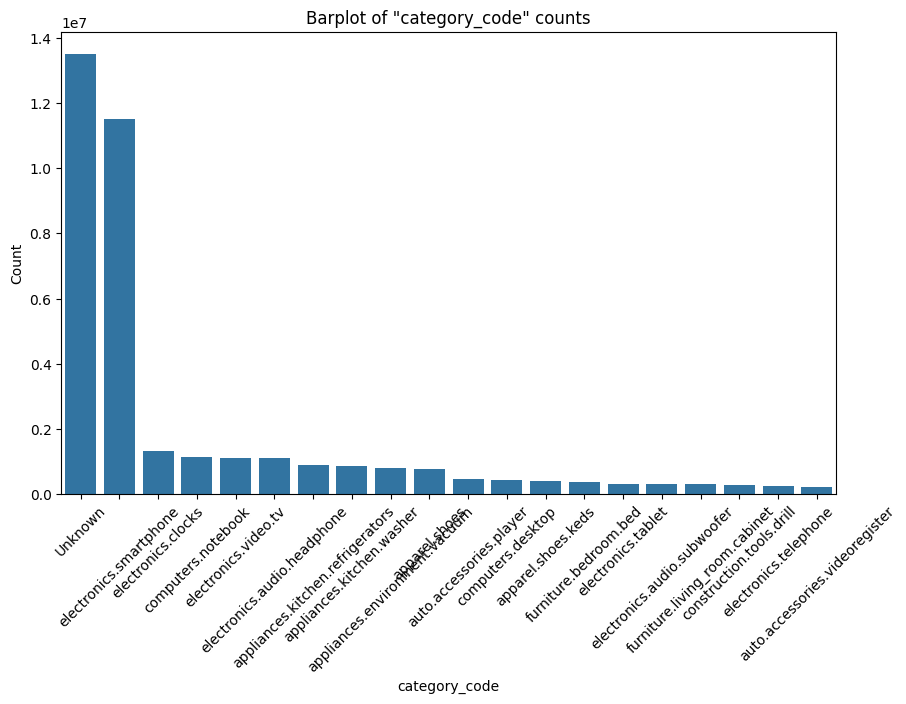

In [52]:
plot_cat_distribution(data=df, column_name="category_code")

PRODUCT_ID

In [53]:
count_nulls(data=df, column_name="product_id")

Число колонок с NULL: 0 (0.00%)


In [54]:
(
    df
    .groupBy("product_id")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show()
)

+----------+------+
|product_id| count|
+----------+------+
|   1004856|500354|
|   1004767|438232|
|   1005115|355786|
|   1004833|237545|
|   1004249|231070|
|   1004870|220501|
|   1005105|215598|
|   4804056|214234|
|   1002544|205597|
|   5100816|189460|
|   1004741|167491|
|   1004836|165769|
|   1004873|153992|
|   1004739|150870|
|   1005160|139673|
|   1002524|134206|
|   1004785|126394|
|   1002633|123521|
|   1005100|122286|
|   1004750|121626|
+----------+------+
only showing top 20 rows



In [55]:
df.filter(col("product_id") == "1004856").show()

+----------+----------+--------------------+-------+------+
|event_type|product_id|       category_code|  brand| price|
+----------+----------+--------------------+-------+------+
|      view|   1004856|electronics.smart...|samsung|130.76|
|      view|   1004856|electronics.smart...|samsung|130.76|
|      view|   1004856|electronics.smart...|samsung|130.76|
|      view|   1004856|electronics.smart...|samsung|130.76|
|  purchase|   1004856|electronics.smart...|samsung|130.76|
|      view|   1004856|electronics.smart...|samsung|130.76|
|      view|   1004856|electronics.smart...|samsung|130.76|
|      view|   1004856|electronics.smart...|samsung|130.76|
|      view|   1004856|electronics.smart...|samsung|130.76|
|      view|   1004856|electronics.smart...|samsung|130.76|
|      view|   1004856|electronics.smart...|samsung|130.76|
|      view|   1004856|electronics.smart...|samsung|130.76|
|      view|   1004856|electronics.smart...|samsung|130.76|
|      view|   1004856|electronics.smart

BRAND

In [56]:
count_nulls(data=df, column_name="brand")

Число колонок с NULL: 6113008 (14.40%)


In [57]:
df = df.fillna({"brand": "Unidentified"})
count_nulls(data=df, column_name="brand")

Число колонок с NULL: 0 (0.00%)


Количество категорий признака brand: 3446


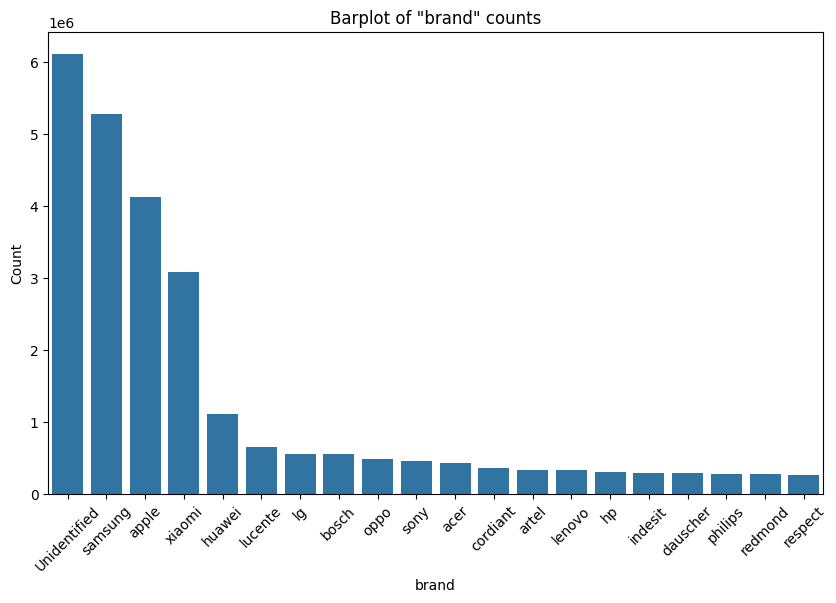

In [58]:
plot_cat_distribution(data=df, column_name="brand")

PRICE

In [59]:
count_nulls(data=df, column_name="price")

Число колонок с NULL: 0 (0.00%)


In [60]:
def plot_boxplots(data: DataFrame,
                  columns: list[str],
                  sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для нескольких столбцов в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        columns (list of str): Список имен столбцов для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    box_data = []

    for column in columns:
        # Вычисление квантилей
        quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
        q1, median, q3 = quantiles

        # Вычисление IQR и границ усов
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Фильтрация выбросов
        filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
        outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

        # Вычисление минимального и максимального значений
        min_value = data.agg({column: "min"}).collect()[0][0]
        mean_value = data.agg({column: "mean"}).collect()[0][0]
        std_value = data.agg({column: "std"}).collect()[0][0]
        max_value = data.agg({column: "max"}).collect()[0][0]

        # Ограничение усов минимальным и максимальным значениями
        lower_bound = max(lower_bound, min_value)
        upper_bound = min(upper_bound, max_value)

        # Семплирование выбросов
        outliers = []
        if not outliers_df.isEmpty():
            sampled_outliers_df = outliers_df.sample(sample_fraction)
            outliers = (
                sampled_outliers_df
                .select(column)
                .limit(1000)
                .collect()
            )
            outliers = [row[column] for row in outliers]
            
            # Добавление минимального и максимального значений, если они 
            # относятся к выбросам и не присутствуют в семпле
            if min_value < lower_bound and min_value not in outliers:
                outliers.append(min_value)
            if max_value > upper_bound and max_value not in outliers:
                outliers.append(max_value)

        # Подготовка данных для axes.bxp
        box_data.append({
            'whislo': lower_bound,  # Нижняя граница усов
            'q1': q1,               # Первый квартиль
            'med': median,          # Медиана
            'q3': q3,               # Третий квартиль
            'whishi': upper_bound,  # Верхняя граница усов
            'fliers': outliers      # Выбросы
        })
        
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bxp(box_data, 
           vert=False, 
           positions=range(1, len(columns) + 1), widths=0.5)
    ax.set_yticks(range(1, len(columns) + 1))
    ax.set_yticklabels(columns)
    ax.set_xlabel('Value')
    ax.set_title('Boxplots')
    ax.grid(True)
    plt.show()

Минимальное значение:          0.00
Среднее значение:              290.32
Среднеквадратичное отклонение: 358.27
Первый квартиль:               64.61
Медиана:                       161.83
Третий квартиль:               358.26
Максимальное значение:         2574.07


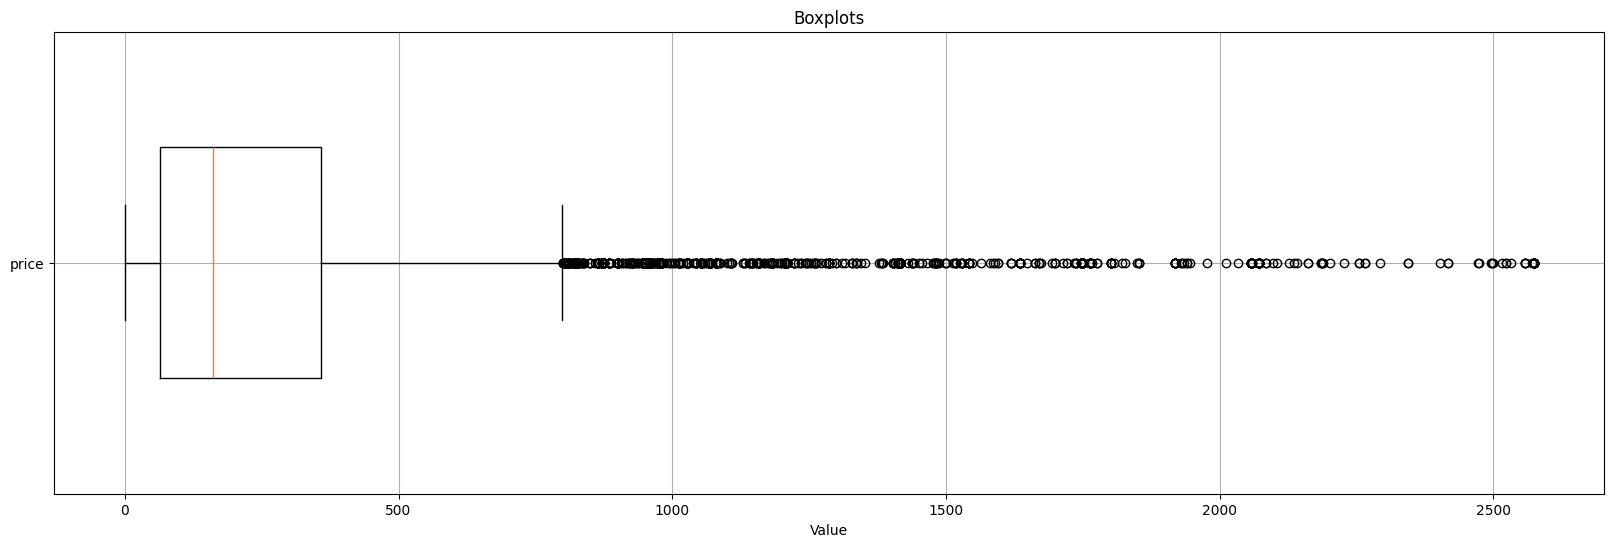

In [61]:
plot_boxplots(data=df, columns=["price"])

In [62]:
def plot_quant_distribution(data: DataFrame,
                            column: str,
                            num_bins: int = 200) -> None:
    """
    Построение гистограммы для количественной переменной с 
    использованием PySpark и Seaborn.

    Args:
        data (DataFrame): DataFrame с данными.
        column_name (str): Название колонки с количественной переменной.
        num_bins (int): Количество бинов для гистограммы.

    Returns:
        None
    """
    # Находим минимальное и максимальное значения колонки
    min_value = data.agg({column: "min"}).collect()[0][0]
    max_value = data.agg({column: "max"}).collect()[0][0]

    # Размер бина
    bin_size = (max_value - min_value) / num_bins

    # Добавляем колонку с номером бина
    data = data.withColumn(
        "bin", 
        floor((col(column) - min_value) / bin_size)
    )

    # Группируем по номеру бина и считаем количество строк в каждом бине
    bin_counts = data.groupBy("bin").count()

    # Преобразуем результат в Pandas DataFrame для построения гистограммы
    bin_counts_pd = bin_counts.limit(1000).toPandas()
    
    # Создаем массив границ бинов
    bin_edges = [min_value + i * bin_size for i in range(num_bins + 2)]
    
    # Преобразуем номера бинов в центры бинов
    bin_centers = [
        (bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins + 1)
    ]
    
    # Добавляем центры бинов в Pandas DataFrame
    bin_counts_pd['bin_center'] = bin_counts_pd['bin'].apply(
        lambda x: bin_centers[int(x)]
    )
    
    # Построение гистограммы с использованием Seaborn
    plt.figure(figsize=(20, 6))
    sns.histplot(data=bin_counts_pd, x="bin_center", 
                 weights="count", kde=True, bins=num_bins + 1)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(f"Распределение количественного признака \"{column}\"")
    plt.grid(True)
    plt.show()

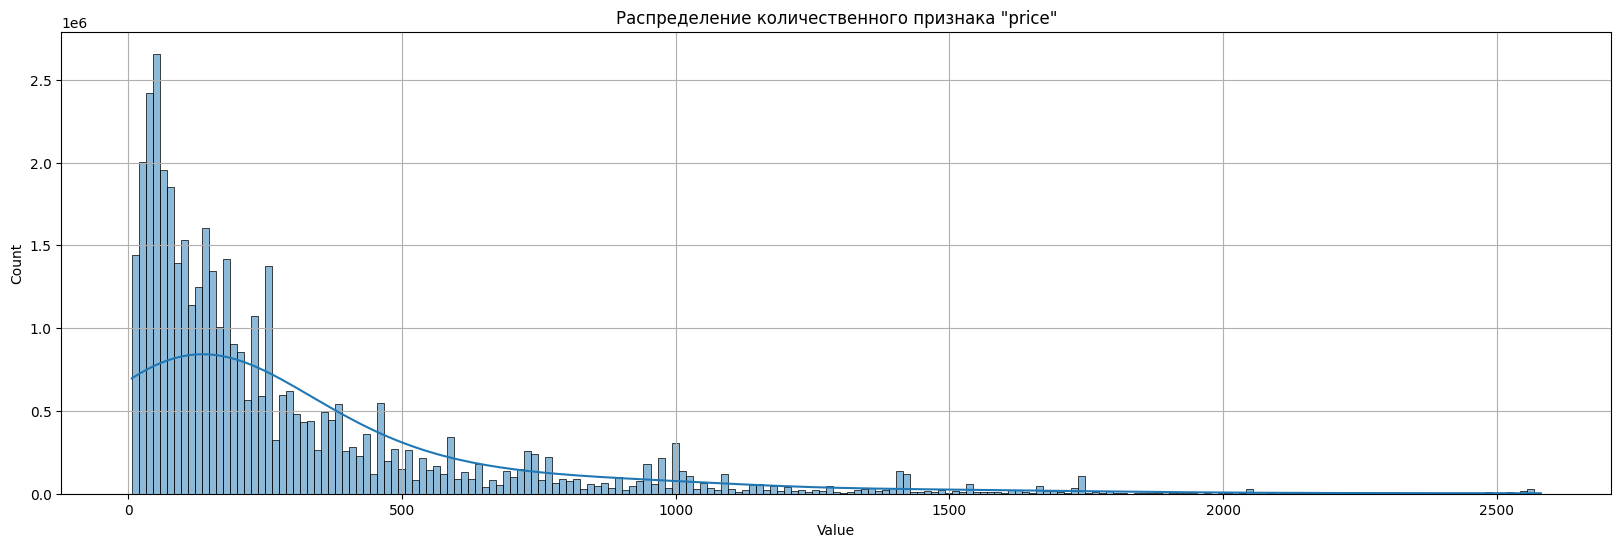

In [63]:
plot_quant_distribution(data=df, column="price")

In [64]:
df = df.withColumn(
    "price",
    when(col("price") > 2000, 2000)
        .otherwise(col("price"))
)

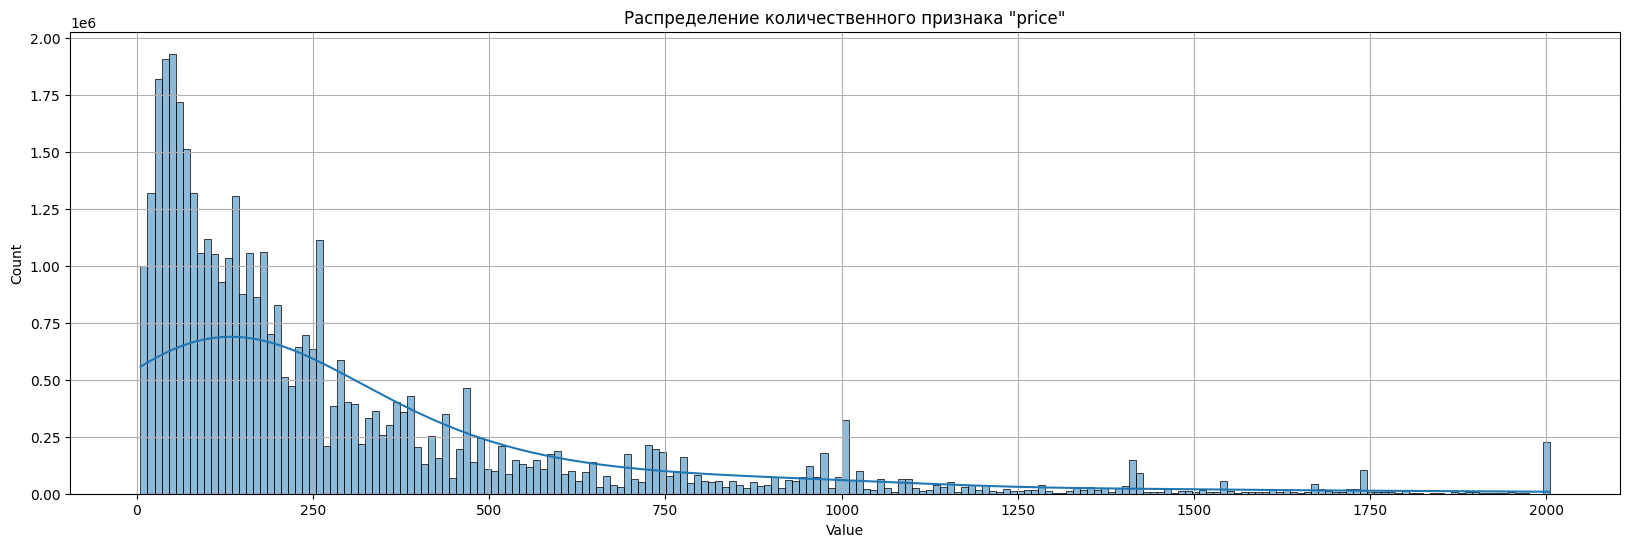

In [65]:
plot_quant_distribution(data=df, column="price")

В датасете только один количественный признак, поэтому ради практики просто проверю корреляцию между price и product_id

In [66]:
def compute_and_visualize_correlation_matrix(data: DataFrame, 
                                             columns: list[str]) -> None:
    """
    Вычисляет и визуализирует корреляционную матрицу для указанных 
    колонок в DataFrame PySpark.

    Args:
        df (DataFrame): DataFrame PySpark.
        columns (list[str]): Список колонок для вычисления корреляции.

    Returns:
        None
    """
    # Вычисление корреляционной матрицы
    corr_matrix = {}
    for col1 in columns:
        corr_matrix[col1] = {}
        for col2 in columns:
            corr_value = data.select(corr(col1, col2)).collect()[0][0]
            corr_matrix[col1][col2] = corr_value

    # Преобразование корреляционной матрицы в DataFrame Pandas для визуализации
    corr_matrix_pd = pd.DataFrame(corr_matrix)

    # Построение и визуализация корреляционной матрицы
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

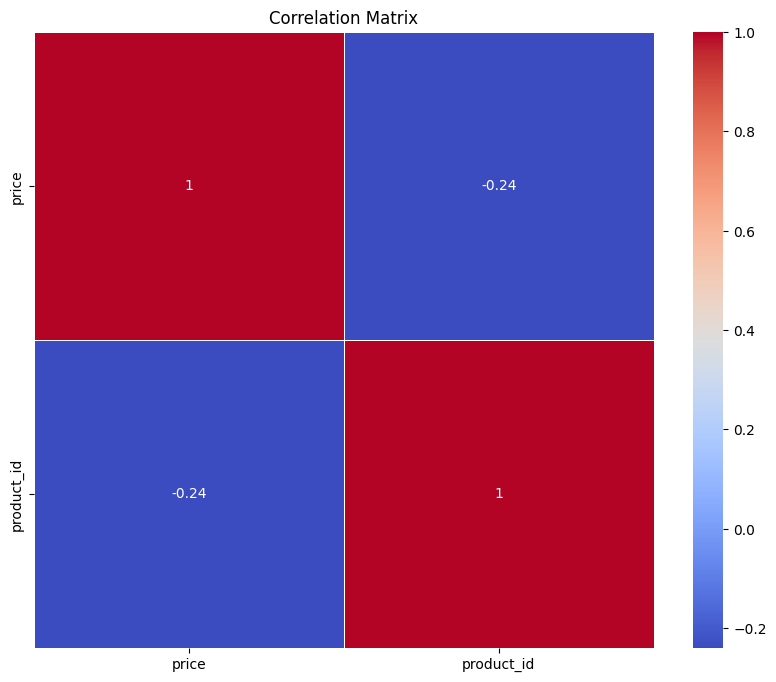

In [67]:
compute_and_visualize_correlation_matrix(
    data=df, columns=[
        "price", "product_id"
    ]
)

In [68]:
df.show()

+----------+----------+--------------------+------------+-------+
|event_type|product_id|       category_code|       brand|  price|
+----------+----------+--------------------+------------+-------+
|      view|  44600062|             Unknown|    shiseido|  35.79|
|      view|   3900821|appliances.enviro...|        aqua|   33.2|
|      view|  17200506|furniture.living_...|Unidentified|  543.1|
|      view|   1307067|  computers.notebook|      lenovo| 251.74|
|      view|   1004237|electronics.smart...|       apple|1081.98|
|      view|   1480613|   computers.desktop|      pulser| 908.62|
|      view|  17300353|             Unknown|       creed| 380.96|
|      view|  31500053|             Unknown|    luminarc|  41.16|
|      view|  28719074|  apparel.shoes.keds|       baden| 102.71|
|      view|   1004545|electronics.smart...|      huawei| 566.01|
|      view|   2900536|appliances.kitche...|    elenberg|  51.46|
|      view|   1005011|electronics.smart...|     samsung| 900.64|
|      vie

In [69]:
df.count()

42448764

In [81]:
spark.sql("DROP TABLE spark_catalog.lopin_database1.sobd_lab1_processed_table")

DataFrame[]

In [ ]:
# Сохранение DataFrame в виде таблицы
# df.writeTo("sobd_lab1_processed_table").using("iceberg").create()

In [78]:
for table in spark.catalog.listTables():
    print(table.name)

sobd_lab1_processed_table
sobd_lab1_table


In [83]:
spark.stop()